### Import Libraries and Load in Dataset

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from itertools import combinations
%matplotlib inline

In [2]:
dataset = pd.read_csv('D:\lianz\Desktop\Python\Data Science Discovery\winequality\winequality-red.csv',sep=';')
interested_cols = list(dataset.columns.drop("quality"))
interested_cols

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

#### Check correlation between features (columns)

<AxesSubplot:>

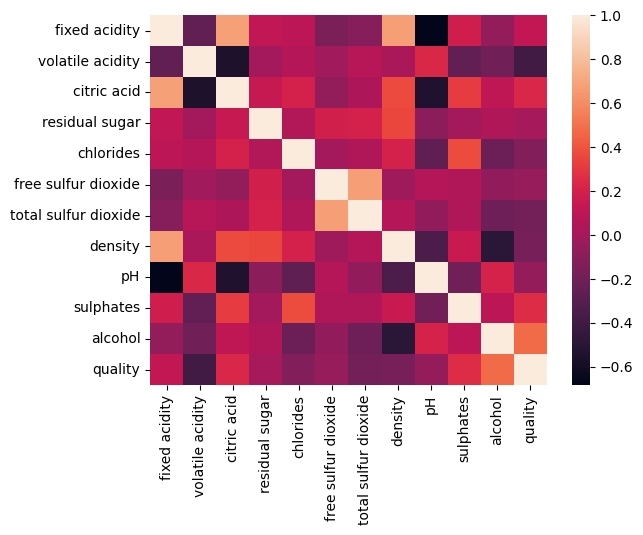

In [28]:
# plot the heatmap
sns.heatmap(dataset.corr())

#### Scatterplot - Numpy test fit

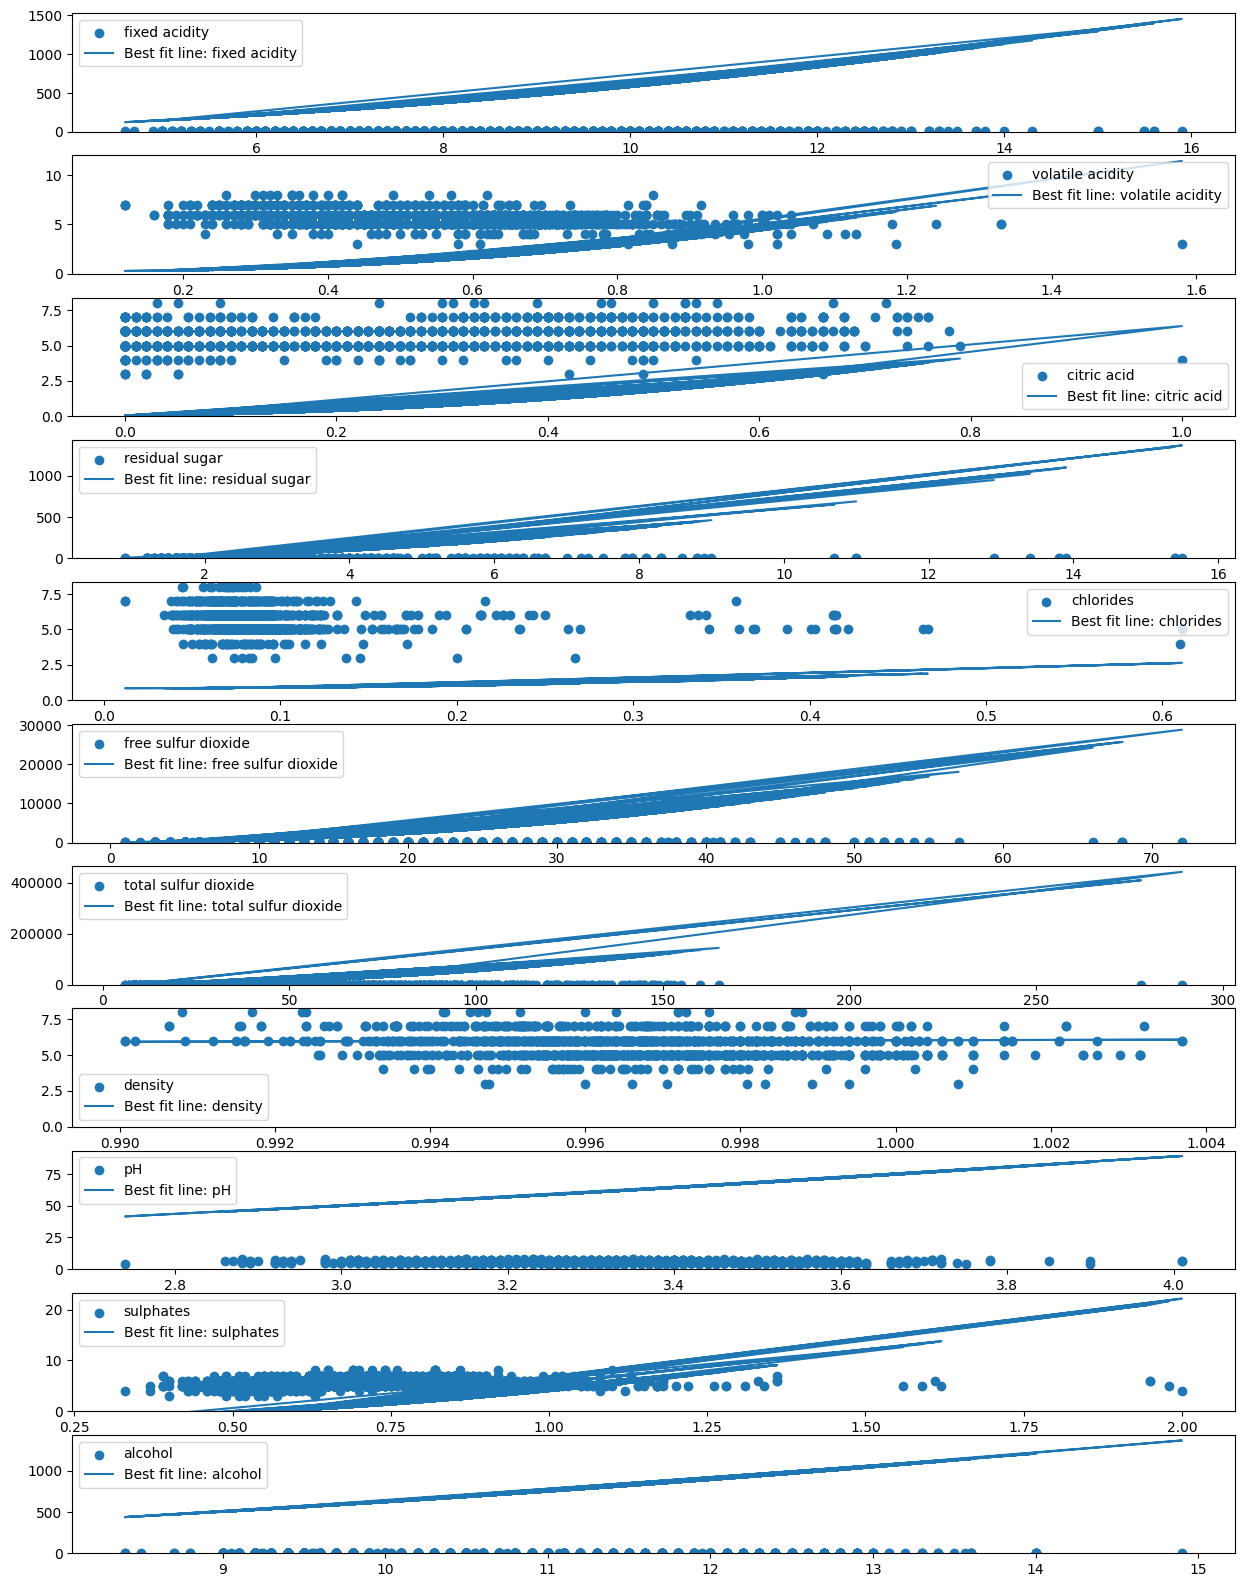

In [3]:
fig, ax = plt.subplots(11, figsize=(15,20))

for i in range(len(interested_cols)):
    ax[i].scatter(dataset[interested_cols[i]], dataset["quality"], label=interested_cols[i])
    a, b, c = np.polynomial.Polynomial.fit(dataset[interested_cols[i]], dataset["quality"],2)
    ax[i].plot(dataset[interested_cols[i]], a*dataset[interested_cols[i]]**2 + b*dataset[interested_cols[i]] + c, label='Best fit line: {}'.format(interested_cols[i]))
    ax[i].legend()
    ax[i].set_ylim(0,)

### 1.1 Linear Regression

In [4]:
import sklearn
from sklearn.linear_model import LinearRegression

#### 1.2 Create train and test datasets

In [5]:
x = dataset[interested_cols]
y = dataset["quality"]
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x,y,test_size=0.1)

dataset.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


#### 1.3 Train linear regression model

In [6]:
reg = LinearRegression()
reg.fit(x_train, y_train)
            
print(f'Coefficients: {reg.coef_}\nIntercept: {reg.intercept_}\nScore: {reg.score(x_train, y_train)}')


Coefficients: [ 2.54709881e-02 -1.10000837e+00 -1.85817879e-01  3.04526401e-02
 -1.83352561e+00  2.69370260e-03 -3.39841096e-03 -2.72110732e+01
 -3.14233898e-01  9.42347301e-01  2.61154442e-01]
Intercept: 31.07087701993729
Score: 0.35667735797376343


#### 1.4 Predict using linear model

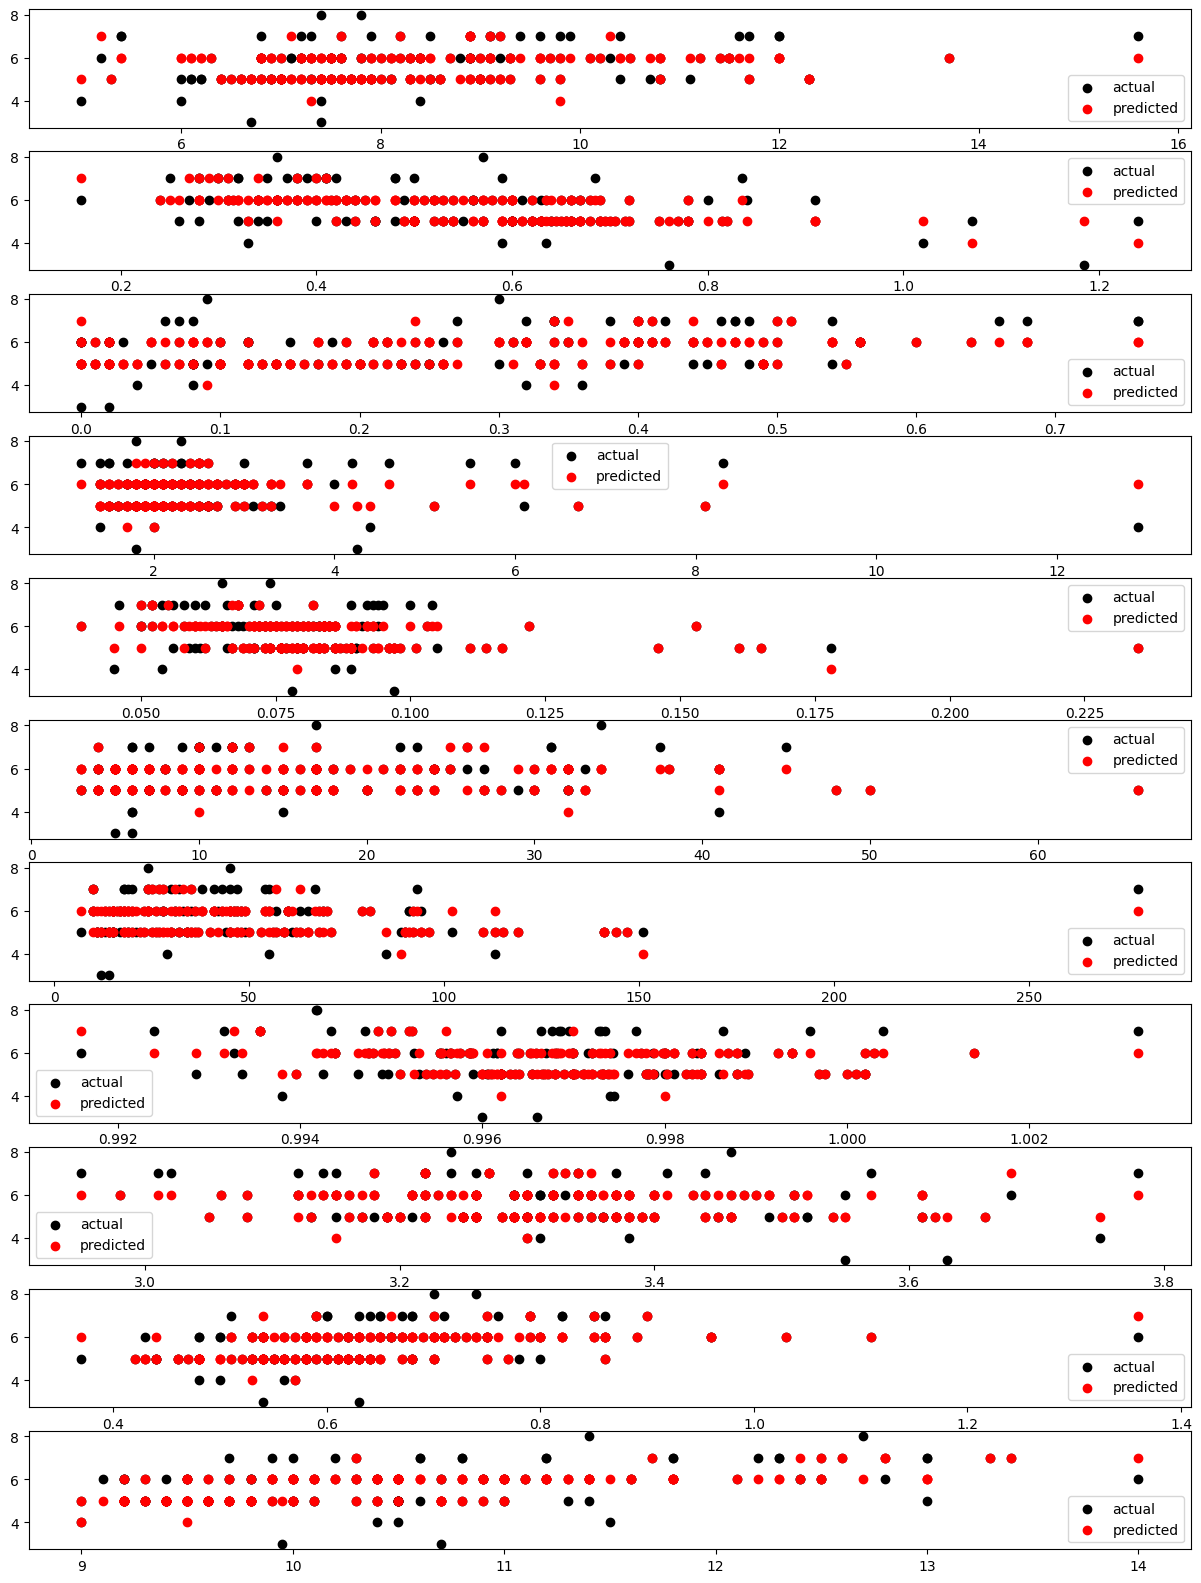

In [7]:
predicted = reg.predict(x_test)

fig2, ax2 = plt.subplots(11, figsize=(15,20))

for i in range(len(interested_cols)):
    ax2[i].scatter(x_test[interested_cols[i]], y_test, label="actual", color='k')
    ax2[i].scatter(x_test[interested_cols[i]], np.around(predicted), label="predicted", color='r')
    ax2[i].legend()



0.5875

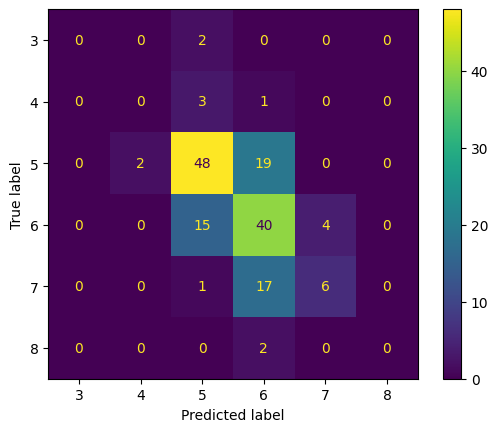

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_test, np.around(predicted))
dp = ConfusionMatrixDisplay.from_predictions(y_test, np.around(predicted))

sum([cm[i][i] for i in range(len(cm))])/160

#### 1.5 Generate combinations of columns to investigate impact of each parameter on winequality

##### 1.5.1 Check number of combinations for this dataset

In [9]:
## 11 columns
## when all 11 are in the list, no combinations possible
## dropping 1 column increases combination by 10 since 1 of each of the 10 columns can be swapped out once
## examples: 
## [1,2,3,4,5,6,7,8,9,10,11] -> [1,2,3,4,5,6,7,8,9,10] + [11]
## [1,2,3,4,5,6,7,8,9,10,11] -> [1,2,3,4,5,6,7,8,9,11] + [10]
## swapping out the dropped column with any columns between 1-11 to make new combination

def factorial(n):
    if n == 0:
        return 1
    else:
        return n*factorial(n-1)

# print(factorial(0))

def number_combinations(n, p):
    return factorial(n) / (factorial(p) * factorial(n-p))

# print(number_combinations(10,10))

n = []
range(1,len(interested_cols))
for i in range(1,len(interested_cols)+1):
    n.append(number_combinations(11,i))

sum(n)


2047.0

##### 1.5.2 Generate combinations using itertools.combinations

In [10]:
column_combinations = []

for i in range(1,len(interested_cols)+1):
    column_combinations += list(combinations(interested_cols, i))


##### 1.5.3 Generate linear model prediction for each combination and return combinations that gives score > 35%

In [11]:
def linear_train(col_comb: list): # input must be list of combinations for columns of interest in dataset
    ## Generate linear model
    lin_reg = LinearRegression()
    dict = {}
    
    ## Create training and testing datasets
    x = dataset[col_comb]
    y = dataset["quality"]
    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x,y,test_size=0.1)

    ## Train linear model
    lin_reg.fit(x_train, y_train)

    ## Predict using linear model
    pred = lin_reg.predict(x_test)

    ## Return coefficients and score in dictionary
    coef_keys = list(range(len(lin_reg.coef_)))
    dict['Coefficients'] = {e: lin_reg.coef_[i] for i, e in enumerate(coef_keys)}
    dict['Intercept'] = lin_reg.intercept_
    dict['Score'] = lin_reg.score(x_test, y_test)
    dict['Columns'] = col_comb

    return dict # returns dictionary with coefficients, intercepts and score of linear model

In [12]:
good_combinations = [linear_train(list(column_combinations[i])) for i in range(len(column_combinations)) if linear_train(list(column_combinations[i]))['Score'] > 0.35]

In [13]:
max(good_combinations[i]['Score'] for i in range(len(good_combinations)))

0.4694381831038539

In [14]:
## Plot number of columns against score of regression model
df_from_goodcomb = pd.DataFrame(data=good_combinations)

## Convert columns into number of columns
df_from_goodcomb['columns_length'] = [len(i) for i in df_from_goodcomb.Columns]
df_from_goodcomb.columns_length.sum()

1713

Text(0, 0.5, 'Linear-model Score')

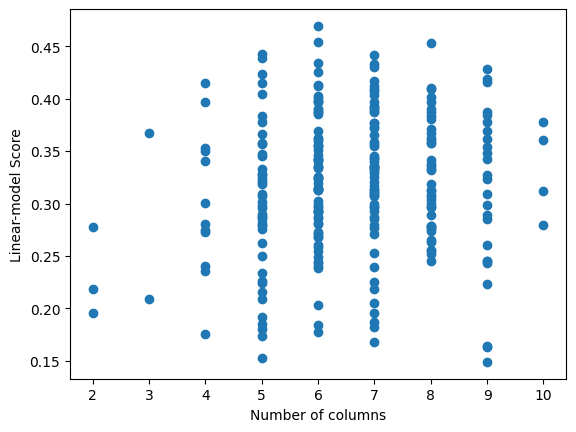

In [15]:
## Plot columns length against core

plt.scatter(df_from_goodcomb.columns_length, df_from_goodcomb.Score)
plt.xlabel('Number of columns')
plt.ylabel('Linear-model Score')

Text(0, 0.5, 'Count of Column Names')

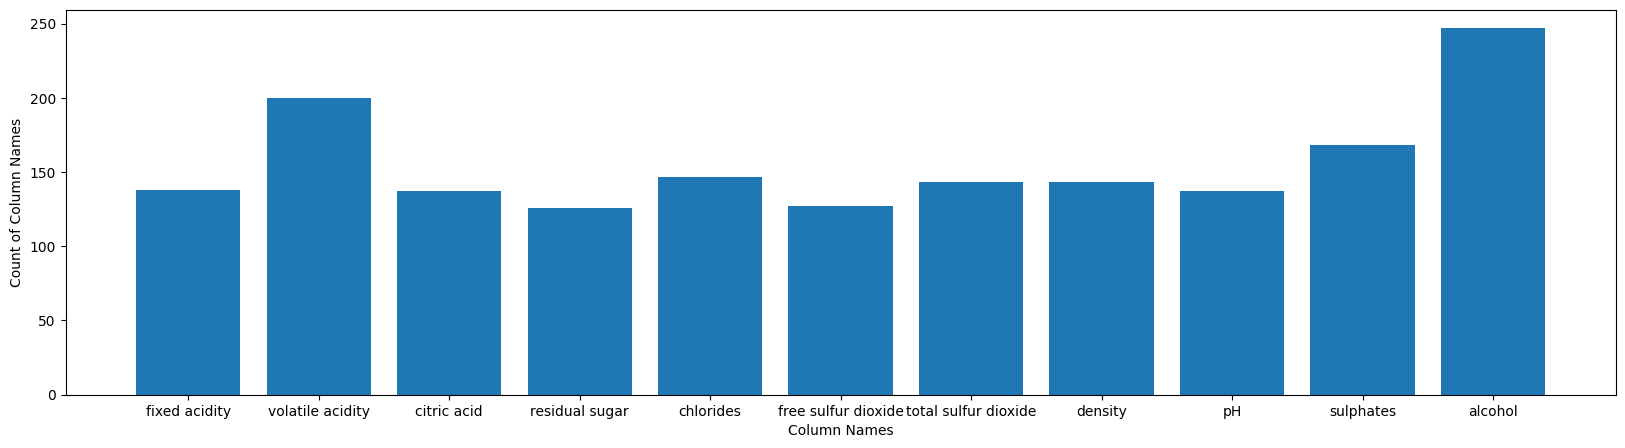

In [16]:
## Find number of times each column came up in 'Columns' to see which columns are most frequently occuring, which may indicate the impact/importance of the columns

col_count = {} # dictionary containing frequency of column appearance in score > 0.35 linear models

for names in interested_cols:
    sum_names = []
    for i in df_from_goodcomb.Columns:
        if names in i:
            sum_names += i
    col_count[names] = sum_names.count(names)


fig3, ax3 = plt.subplots(1,1, figsize=(20,5))

ax3.bar(col_count.keys(), col_count.values())
ax3.set_xlabel('Column Names')
ax3.set_ylabel('Count of Column Names')


### 2.1 Generalize Model

#### 2.1.1 Function to save model via looping

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def train_model(algorithm: str, num: int, data: pd.DataFrame, train_test_split):
    global best_arrays

    ## Define global variable to be accessed outside of function
    # global best_arrays


    ## Generate all column combinations using itertools
    column_combinations = []
    col_of_interest = list(data.columns.drop("quality"))
    print(col_of_interest)

    for i in range(1,len(col_of_interest)+1):
        column_combinations += list(combinations(col_of_interest, i))

    print(len(column_combinations))
    

    ## Split data into train and test sets for each column combination
    
    for j in range(len(column_combinations[:])):
        for i in range(num):
            ## Load in previous model if available
            try: #### (!)issue here is that everytime it loads the saved pickle, the best is error because the training and test sets have different number of columns
                pickle_in = open(f"{algorithm.split('(')[0]}_model.pickle", "rb")
                model = pickle.load(pickle_in)
                best_arr = pd.read_csv(f"{algorithm.split('(')[0]}_best_array.csv")
                best = model.score(best_arr.iloc[-round(len(best_arr.index)*train_test_split):,:-1], best_arr.iloc[-round(len(best_arr.index)*train_test_split):,-1:])

            except:
                best = 0
    
        
            x = data[list(column_combinations[j])]
            y = data.iloc[:, -1]
            x_tr, x_te, y_tr, y_te = sklearn.model_selection.train_test_split(x,y,test_size=train_test_split)


            ## Loop to try for best score on model
            model = eval(algorithm)
            model.fit(x_tr, y_tr)
            acc = model.score(x_te, y_te)

            if acc > best:

                best_arrays = [x_tr,x_te,y_tr,y_te]
                best = acc
                with open(f"{algorithm.split('(')[0]}_model.pickle", "wb") as f:
                    pickle.dump(model, f)
                print(best)
            
                df1 = pd.DataFrame(best_arrays[0])
                df1['quality'] = best_arrays[2]
                df2 = pd.DataFrame(best_arrays[1])
                df2['quality'] = best_arrays[3]

                pd.concat([df1,df2], axis=0).to_csv(f"{algorithm.split('(')[0]}_best_array.csv", index=False)

    return f'Training completed for {num*len(column_combinations)} times'

In [20]:
train_model('DecisionTreeClassifier()',10, dataset, 0.1)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
2047
0.74375
0.75


'Training completed for 20470 times'

#### 2.1.2 Load in model

In [21]:
pickle_in = open("DecisionTreeClassifier_model.pickle", "rb")
dtree = pickle.load(pickle_in)

df_dtree = pd.read_csv('DecisionTreeClassifier_best_array.csv')
best_x = df_dtree.iloc[-160:,:-1]
best_y = df_dtree.iloc[-160:,-1:]
dtree_predictions = dtree.predict(best_x)
dtree.score(best_x, best_y)

0.75

#### 2.1.3 Evaluation of the Model - Confusion Matrix

0.75

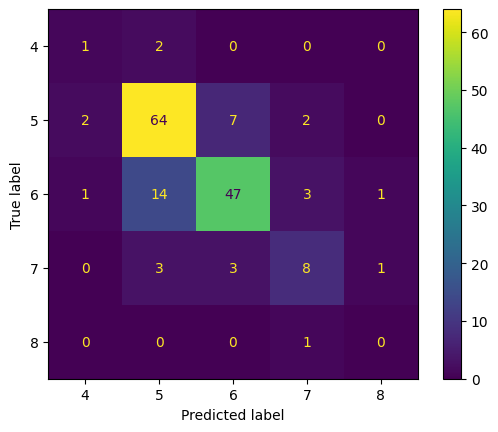

In [22]:
dtree_cm = confusion_matrix(best_y, dtree_predictions)
dtree_dp = ConfusionMatrixDisplay.from_predictions(best_y, dtree_predictions)

accuracy = sum([dtree_cm[i][i] for i in range(len(dtree_cm))])/sum(sum(dtree_cm))
accuracy

#### 2.1.4 Evaluation of the Model - Cross-validation

In [23]:
from sklearn.model_selection import cross_val_score

scr = cross_val_score(dtree, df_dtree.iloc[:,:-1], df_dtree.iloc[:,-1:], cv=10)
scr.mean()

0.6379245283018868

#### 2.1.4 Visualizing the tree 

[Text(0.5002019883873795, 0.9736842105263158, 'X[8] <= 10.25\ngini = 0.647\nsamples = 1439\nvalue = [10, 50, 606, 572, 184, 17]'),
 Text(0.23927065074496057, 0.9210526315789473, 'X[1] <= 0.548\ngini = 0.524\nsamples = 749\nvalue = [7, 28, 463, 226, 23, 2]'),
 Text(0.1250985977212971, 0.868421052631579, 'X[5] <= 60.5\ngini = 0.572\nsamples = 331\nvalue = [1, 7, 166, 138, 17, 2]'),
 Text(0.05598159509202454, 0.8157894736842105, 'X[7] <= 0.585\ngini = 0.592\nsamples = 233\nvalue = [1, 6, 93, 115, 16, 2]'),
 Text(0.024539877300613498, 0.7631578947368421, 'X[8] <= 9.65\ngini = 0.523\nsamples = 71\nvalue = [0, 5, 43, 23, 0, 0]'),
 Text(0.012620508326029798, 0.7105263157894737, 'X[4] <= 8.5\ngini = 0.427\nsamples = 47\nvalue = [0, 3, 34, 10, 0, 0]'),
 Text(0.0098159509202454, 0.6578947368421053, 'gini = 0.0\nsamples = 17\nvalue = [0, 0, 17, 0, 0, 0]'),
 Text(0.015425065731814198, 0.6578947368421053, 'X[3] <= 0.082\ngini = 0.558\nsamples = 30\nvalue = [0, 3, 17, 10, 0, 0]'),
 Text(0.0084136722

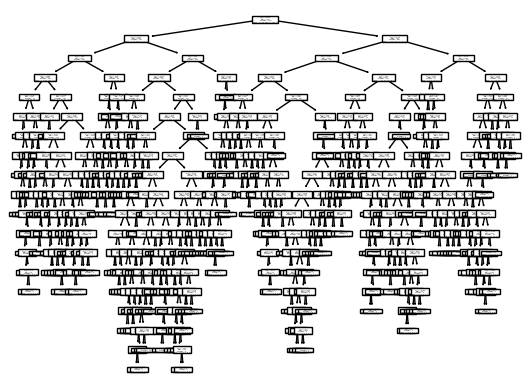

In [24]:
from sklearn import tree

tree.plot_tree(dtree)